In [1]:
from praatio import textgrid

In [2]:
from paths import *

In [3]:
tg_try_path = train_tg_ + "19/198/19-198-0011.TextGrid"

In [4]:
tg = textgrid.openTextgrid(tg_try_path, False)

In [5]:
entries = tg.getTier("phones").entries # Get all intervals

In [7]:
entries[0].end

0.27

In [8]:
import torchaudio
from torchaudio import transforms
from paths import *

In [9]:
audio_try_path = train_audio_ + "19/198/19-198-0011.flac"

In [10]:
waveform, sample_rate = torchaudio.load(audio_try_path)

In [11]:
waveform.shape

torch.Size([1, 223120])

In [12]:
print(torchaudio.info(audio_try_path))

AudioMetaData(sample_rate=16000, num_frames=223120, num_channels=1, bits_per_sample=16, encoding=FLAC)


In [13]:
sample_rate

16000

/home/ldlmdl/anaconda3/envs/lffl/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


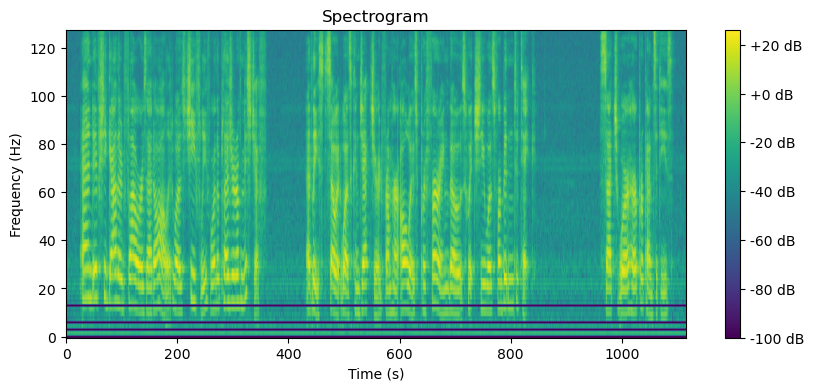

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

In [14]:
import torchaudio
import torch
import matplotlib.pyplot as plt

# Load your audio file (replace 'your_audio.wav' with your audio file path)
audio_path = train_audio_ + "19/198/19-198-0011.flac"
waveform, sample_rate = torchaudio.load(audio_path)

# Compute the spectrogram
n_fft = 400  # Number of FFT points
win_length = 400  # Window size
hop_length = 160  # Hop size
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

# Convert to decibels (dB)
specgram_db = torchaudio.transforms.AmplitudeToDB()(specgram)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(specgram_db[0].numpy(), cmap='viridis', aspect='auto', origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Find the frequency range with high intensity
# You can analyze the spectrogram_db tensor to identify the frequency range with high intensity.
# For example, you can find the maximum intensity frequency bin along the time axis.
max_intensity_bin = torch.argmax(specgram_db, dim=1)
frequencies = torchaudio.transforms.MelScale()(torch.arange(specgram_db.shape[2]))
max_intensity_freq = frequencies[max_intensity_bin[0]].item()

print(f"The frequency with the highest intensity is approximately {max_intensity_freq:.2f} Hz.")


In [8]:
import torchaudio
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load your audio file (replace 'your_audio.wav' with the actual file path)
waveform, sample_rate = torchaudio.load(dev_cut_audio_ + "8842-304647-0013-86.flac")

# Compute the Mel spectrogram
mel_spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

# Convert the Mel spectrogram to a NumPy array
mel_spectrogram = mel_spectrogram.numpy()

# Calculate the mean intensity for each frequency bin
mean_intensity = np.mean(mel_spectrogram, axis=1)

# Find the frequency bin with the highest mean intensity
dominant_bin = np.argmax(mean_intensity)

# Define a frequency range around the dominant frequency bin
# You can adjust the range as needed
frequency_range = (dominant_bin - 5, dominant_bin + 5)

# Get the corresponding frequencies for the range
frequency_bins = torchaudio.transforms.MelScale(n_mels=mel_spectrogram.shape[0])(torch.arange(mel_spectrogram.shape[0]))

# Extract the frequencies within the specified range
major_frequency_range = frequency_bins[frequency_range]

# Print the major frequency range
print("Major Frequency Range (Hz):", major_frequency_range)

# Plot the mean intensity to visualize the concentration
plt.figure(figsize=(10, 4))
plt.plot(frequency_bins, mean_intensity)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mean Intensity")
plt.title("Mean Intensity vs. Frequency")
plt.show()


c:\Users\46021\.conda\envs\lffl\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

In [ ]:
    # Create a table to store the segment information
    table_data = {
        'segment': [],
        'file': [],
        'id': [],
        'startTime': [],
        'endTime': [],
        'nSample': []
    }
    segment_table = pd.DataFrame(table_data)

    # Loop through outer directories
    for outer_dir in os.listdir(dir_audio):
        outer_dir_path = os.path.join(dir_audio, outer_dir)

        if not PU.path_isdir(outer_dir_path):
            continue

        # Create the corresponding output directory
        out_outer_dir_path = os.path.join(dir_out, outer_dir)
        PU.mk(out_outer_dir_path)

        # Loop through inner directories
        for inner_dir in os.listdir(outer_dir_path):
            inner_dir_path = os.path.join(outer_dir_path, inner_dir)

            if not os.path.isdir(inner_dir_path):
                continue

            # Create the corresponding output directory
            out_inner_dir_path = os.path.join(out_outer_dir_path, inner_dir)
            os.makedirs(out_inner_dir_path, exist_ok=True)

            # Loop through audio files in the inner directory
            audio_files = [file for file in os.listdir(inner_dir_path) if file.endswith(".flac")]

            for audio_file in audio_files:
                audio_name = os.path.splitext(audio_file)[0]
                textgrid_file = audio_name + ".TextGrid"

                audio_file_path = os.path.join(inner_dir_path, audio_file)
                textgrid_file_path = os.path.join(dir_text, outer_dir, inner_dir, textgrid_file)

                # Read the TextGrid file
                tg = textgrid.openTextgrid(textgrid_file_path)

                # Extract and save audio segments
                for interval in tg.tiers[1]:
                    label = interval.label
                    start_time = interval.start
                    end_time = interval.end

                    if label not in ["sil", "sp", ""]:
                        n_samples = int((end_time - start_time) * tg.min_timestamp / 1000.0)

                        # Extract and save audio segment
                        waveform, sample_rate = torchaudio.load(audio_file_path)
                        start_sample = int(start_time * sample_rate / 1000.0)
                        end_sample = start_sample + n_samples
                        segment = waveform[:, start_sample:end_sample]

                        out_audio_file = os.path.join(out_inner_dir_path, f"{audio_name}-{label}.flac")
                        torchaudio.save(out_audio_file, segment, sample_rate)

                        # Add segment information to the table
                        segment_table = segment_table.append({
                            'segment': label,
                            'file': audio_name,
                            'id': str(interval.index),
                            'startTime': start_time,
                            'endTime': end_time,
                            'nSample': n_samples
                        }, ignore_index=True)

    # Save the segment information to a CSV file
    segment_table.to_csv(os.path.join(dir_path, "log.csv"), index=False)
